## Prueba de modelos ##

### Version 4: Modelo con 2 DER, planificación anual, granularidad horaria ###

Si el modelo tiene que optimizar el balance por horas, tiene 8640 VD, pero sigue teniendo 2 VD binarias

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import pandapower as pp

In [5]:
import pyomo.environ as pe

In [6]:
import matplotlib.pyplot as plt

In [7]:
import ModelWriters as mw

In [8]:
import ModelWriters.Scenes as Scenes

In [9]:
import ModelWriters.Resources as Resources

In [10]:
net = pp.create_empty_network() 
b0 = pp.create_bus(net, vn_kv=13.2)  #0

pp.create_ext_grid(net, bus=b0)

#ramal 1
b11 = pp.create_bus(net, vn_kv=13.2)  #1
b12 = pp.create_bus(net, vn_kv=13.2)  #2
b113 = pp.create_bus(net, vn_kv=13.2)  #3

pp.create_line(net, from_bus=b0, to_bus=b11, length_km=0.8, std_type="NAYY 4x50 SE") #0
pp.create_line(net, from_bus=b11, to_bus=b12, length_km=2.1, std_type="NAYY 4x50 SE") #1
pp.create_line(net, from_bus=b11, to_bus=b113, length_km=1.73, std_type="NAYY 4x50 SE") #2

pp.create_sgen(net, b113, p_mw=0.075, q_mvar=0.025, max_p_mw=0.15, max_q_mvar=0.15)
pp.create_load(net, bus=b12, p_mw=0.350)

#ramal 2
b21 = pp.create_bus(net, vn_kv=13.2) #3
pp.create_line(net, from_bus=b0, to_bus=b21, length_km=5.0, std_type="NAYY 4x50 SE")
pp.create_sgen(net, b21, p_mw=0.15, q_mvar=0.00, max_p_mw=0.40, max_q_mvar=0.10)
pp.create_storage(net, bus=b21, p_mw=0.25, q_mvar=0.1, max_e_mwh = 3.0)

#ramal 3
b31 = pp.create_bus(net, vn_kv=13.2) #4
b32 = pp.create_bus(net, vn_kv=13.2) #5
pp.create_line(net, from_bus=b0, to_bus=b31, length_km=0.5, std_type="NAYY 4x50 SE")
pp.create_line(net, from_bus=b31, to_bus=b32, length_km=1.5, std_type="NAYY 4x50 SE")
pp.create_sgen(net, b31, p_mw=0.08, q_mvar=0.00, max_p_mw=0.30, max_q_mvar=0.10)
pp.create_load(net, bus=b32, p_mw=0.85, q_mvar=0.33)


#ramal 4
b41 = pp.create_bus(net, vn_kv=13.2) #6
pp.create_line(net, from_bus=b0, to_bus=b41, length_km=0.5, std_type="NAYY 4x50 SE")
pp.create_load(net, bus=b41, p_mw=0.22, q_mvar=0.05)
#pp.create_storage(net, bus=b41, p_mw=0.5, q_mvar=0.1, max_e_mwh = 5.0)


net.line['max_i_ka'][2] = 0.35/(1.73*13.2)

In [11]:
net.line

,name,std_type,from_bus,to_bus,length_km,r_ohm_per_km,x_ohm_per_km,c_nf_per_km,g_us_per_km,max_i_ka,df,parallel,type,in_service
0,None,NAYY 4x50 SE,0,1,0.80,0.642,0.083,210.0,0.0,0.142000,1.0,1,cs,True
1,None,NAYY 4x50 SE,1,2,2.10,0.642,0.083,210.0,0.0,0.142000,1.0,1,cs,True
2,None,NAYY 4x50 SE,1,3,1.73,0.642,0.083,210.0,0.0,0.015327,1.0,1,cs,True
3,None,NAYY 4x50 SE,0,4,5.00,0.642,0.083,210.0,0.0,0.142000,1.0,1,cs,True
4,None,NAYY 4x50 SE,0,5,0.50,0.642,0.083,210.0,0.0,0.142000,1.0,1,cs,True
5,None,NAYY 4x50 SE,5,6,1.50,0.642,0.083,210.0,0.0,0.142000,1.0,1,cs,True
6,None,NAYY 4x50 SE,0,7,0.50,0.642,0.083,210.0,0.0,0.142000,1.0,1,cs,True


In [ ]:
 pp.runpp(net)

In [ ]:
print(net.res_bus.vm_pu)
print(net.res_line)

In [ ]:
print(net)

## Construcción de Escenarios

In [26]:
#s = Scenes.SceneBuilder(years = 4, subperiods = 1, days_in_subperiods = 1, dt=24, growth_rate = 0.025, discount_rate = 0.05)
#s = Scenes.SceneBuilder(years = 4, subperiods = 4, days_in_subperiods = 1, dt=1, growth_rate = 0.025, discount_rate = 0.05)
#s = Scenes.SceneBuilder(years = 20, subperiods = 4, days_in_subperiods = 5, dt=2, growth_rate = 0.025, discount_rate = 0.03)
s = Scenes.SceneBuilder(years = 20, subperiods = 12, days_in_subperiods = 7, growth_rate = 0.025, discount_rate = 0.03)
#s = Scenes.SceneBuilder(years = 20, subperiods = 1, days_in_subperiods = 365, dt = 1, growth_rate = 0.025, discount_rate = 0.03)
scenes = s.build_scenes()
scenes

,year,day,dd,hour,dt,growth,discount,solar_irradiance,wind_speed
0,0.0,0.0,4.345238,0.0,1.0,1.00000,1.000000,0.0,0.213405
1,0.0,0.0,4.345238,1.0,1.0,1.00000,1.000000,0.0,0.502001
2,0.0,0.0,4.345238,2.0,1.0,1.00000,1.000000,0.0,4.306551
3,0.0,0.0,4.345238,3.0,1.0,1.00000,1.000000,0.0,6.641419
4,0.0,0.0,4.345238,4.0,1.0,1.00000,1.000000,0.0,7.224915
...,...,...,...,...,...,...,...,...,...
40315,19.0,336.0,4.345238,19.0,1.0,1.59865,0.570286,0.0,13.318767
40316,19.0,336.0,4.345238,20.0,1.0,1.59865,0.570286,0.0,12.680171
40317,19.0,336.0,4.345238,21.0,1.0,1.59865,0.570286,0.0,10.830872
40318,19.0,336.0,4.345238,22.0,1.0,1.59865,0.570286,0.0,10.205050


## Model Construction

Construccion automatica del modelo
Es un modelo de dimensionamiento de 3 DERs (WT+PV)

In [47]:
#model_writer = mw.MultiBusbarModelWriter(net, scenes, overload_cost = 2.0)
#model_writer = mw.MultiBusbarModelWriter(net, scenes, overload_cost = None)
#model_writer = mw.MultiBusbarModelWriter(net, scenes, overload_hours = 4000)
model_writer = mw.MultiBusbarModelWriter(net, scenes, overload_hours = 15000)

In [48]:
net.ext_grid['model'][0] = Resources.ExtGrid('SET', pr_mw = 5.0, peak_value=200, valley_value=120, rest_value=160)
#net.ext_grid['model'][0] = Resources.ExtGrid('SET', pr_mw = 5.0, peak_value=2000, valley_value=1500, rest_value=1000)

In [49]:
net.load['model'][0] = Resources.Load('Tornquinst', pr_mw = 0.35)
net.load['model'][1] = Resources.Load('Bell Ville', pr_mw = 0.85)
net.load['model'][2] = Resources.Load('City Bell', pr_mw = 0.22)

In [50]:
net.sgen['model'][0] = Resources.PVGenerator('PV1', ic_0_mu = 0.0, ic_1_mu = 1.02e6, oc_0_mu = 1.02, oc_1_mu = 0.0)
net.sgen['model'][1] = Resources.WTGeneratorDiscrete('WT1', unit_size_mw = 0.19, unit_cost_mu = 541e3, oc_0_mu = 0.00, oc_1_mu = 1.70)
#net.sgen['model'][2] = Resources.PVGeneratorDiscrete('PV2', unit_size_mw = 0.05, unit_cost_mu = 51e3, oc_0_mu = 0.03, oc_1_mu = 0.0)

In [51]:
net.storage['model'][0] = Resources.Storage('ST1', ic_1_mu = 554e3, ic_1_mu_cap = 330e3, oc_1_mu = 2.28*4, eta_bb = 0.8, sigma = 2.1e-3)

## Resolution

In [52]:
model = model_writer.create_model()

In [34]:
if len(scenes) < 40:
    model.pprint()

In [53]:
#solver_manager = pe.SolverManagerFactory('neos')
#result_obj = solver_manager.solve(model.model, opt='cplex')

opt = pe.SolverFactory('cplex')
#opt = pe.SolverFactory('glpk')
result_obj= opt.solve(model, tee=True)


Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 20.1.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2020.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile 'C:\Users\jmsar\AppData\Local\Temp\tmp18tmavdt.cplex.log' open.
CPLEX> Problem 'C:\Users\jmsar\AppData\Local\Temp\tmp9vh9rt0d.pyomo.lp' read.
Read time = 5.69 sec. (226.22 ticks)
CPLEX> Problem name         : C:\Users\jmsar\AppData\Local\Temp\tmp9vh9rt0d.pyomo.lp
Objective sense      : Minimize
Variables            : 1330569  [Nneg: 120965,  Box: 322560,  Free: 40320,
                                 Binary: 846723,  General Integer: 1]
Objective nonzeros   :  120965
Linear constraints   : 2016013  [Less: 1370891,  Equal: 645122]
  Nonzeros           : 4696511
  RHS nonzeros       : 1249928

Va

ApplicationError: Solver (cplex) did not exit normally

In [36]:
model_writer.backconfigure_network()

In [37]:
model_writer.net.sgen

,name,bus,p_mw,q_mvar,sn_mva,scaling,in_service,type,current_source,max_p_mw,max_q_mvar,model
0,None,3,0.075,0.025,NaN,1.0,True,wye,True,1.21124,0.60562,Resource: PV1
1,None,4,0.150,0.000,NaN,1.0,True,wye,True,1.71000,0.85500,Resource: WT1
2,None,5,0.080,0.000,NaN,1.0,True,wye,True,0.30000,0.10000,None


In [358]:
net.sgen['model'][2].units.value

AttributeError: 'NoneType' object has no attribute 'units'

In [38]:
model_writer.net.storage

,name,bus,p_mw,q_mvar,sn_mva,soc_percent,min_e_mwh,max_e_mwh,scaling,in_service,type,model
0,None,4,0.25,0.1,NaN,NaN,0.0,3.656077,1.0,True,None,Resource: ST1


In [39]:
Resultados = model_writer.get_scenes_results()

In [40]:
Resultados

,SET_p_mw,Tornquinst_p_mw,Bell Ville_p_mw,City Bell_p_mw,PV1_p_mw,WT1_p_mw,ST1_p_mw,ST1_soc_mwh,L 0_1_pf_mw,L 1_2_pf_mw,L 1_3_pf_mw,L 0_4_pf_mw,L 0_5_pf_mw,L 5_6_pf_mw,L 0_7_pf_mw
0,3.712917e-01,-0.082565,-0.228337,-0.060390,0.0,0.000000,0.000000,0.000000,-0.082565,-0.082565,-0.0,0.000000,-0.228337,-0.228337,-0.060390
1,1.128786e+00,-0.074207,-0.164733,-0.056856,0.0,0.000000,-0.832990,0.666392,-0.074207,-0.074207,-0.0,-0.832990,-0.164733,-0.164733,-0.056856
2,1.230848e+00,-0.080588,-0.178846,-0.059444,0.0,0.027004,-0.938974,1.416172,-0.080588,-0.080588,-0.0,-0.911970,-0.178846,-0.178846,-0.059444
3,1.180660e+00,-0.094685,-0.233909,-0.048923,0.0,0.135831,-0.938974,2.164377,-0.094685,-0.094685,-0.0,-0.803143,-0.233909,-0.233909,-0.048923
4,1.077310e+00,-0.073883,-0.188869,-0.054418,0.0,0.178833,-0.938974,2.911011,-0.073883,-0.073883,-0.0,-0.760141,-0.188869,-0.188869,-0.054418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40315,2.056312e-01,-0.700125,-1.266310,-0.371089,0.0,1.192919,0.938974,1.785197,-0.700125,-0.700125,-0.0,2.131893,-1.266310,-1.266310,-0.371089
40316,9.268946e-01,-0.701935,-1.719757,-0.471711,0.0,1.027534,0.938974,1.030269,-0.701935,-0.701935,-0.0,1.966508,-1.719757,-1.719757,-0.471711
40317,1.392671e+00,-0.530993,-1.641627,-0.426365,0.0,0.635144,0.571170,0.571170,-0.530993,-0.530993,-0.0,1.206314,-1.641627,-1.641627,-0.426365
40318,2.027623e-02,-0.232600,-0.506089,-0.127267,0.0,0.529030,0.316650,0.316650,-0.232600,-0.232600,-0.0,0.845680,-0.506089,-0.506089,-0.127267


In [41]:
def plot_results(results, a = 0, b = 240, items = None, elements = False, lines = False, l_ep = False):
    # Set the plot curve with markers and a title
    if not (elements or lines or l_ep or items):
        raise Exception("Nothing to plot")
    
    fig, ax = plt.subplots(1, 1)

    fig.set_size_inches(10,6)
    
    for col in results:
        p = False
        if items and col in items:
            p = True
        elif col[0:2] == 'L ':
            if col[-4:] == 'ep_h':
                if l_ep:
                    p = True
            elif lines:
                p = True
        elif elements:
            p = True

        if p:
            ax.plot(results[col][a:b], label = col)
    
    ax.set_xlabel('time')
    ax.set_ylabel('P[mw]')

    ax.legend()

    ax.grid(True)


    plt.show()
    

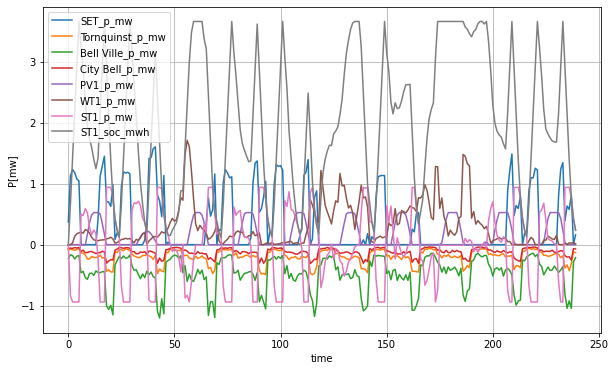

In [42]:
plot_results(Resultados, a = 0, b = 240, elements = True, lines = False, l_ep = False)

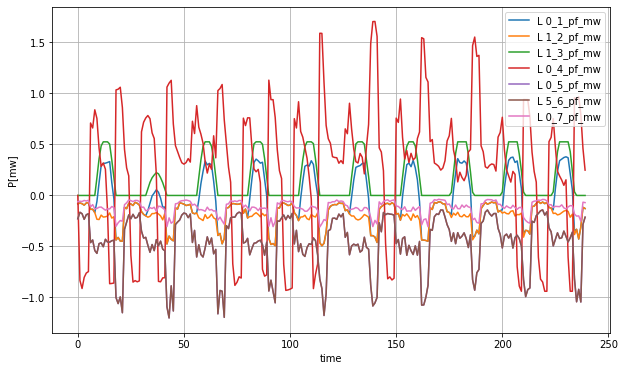

In [43]:
plot_results(Resultados, a = 0, b = 240, lines = True)

No handles with labels found to put in legend.


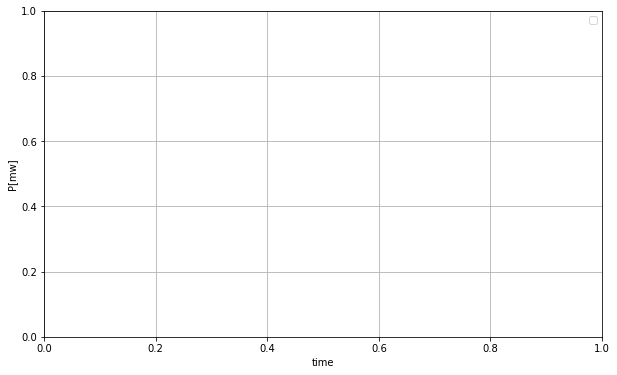

In [44]:
plot_results(Resultados, a = 0, b = 240, l_ep = True)

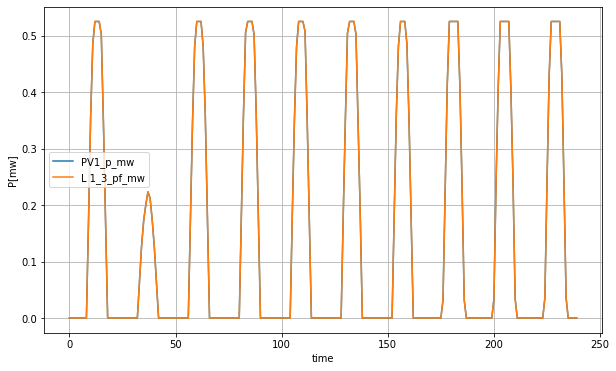

In [45]:
plot_results(Resultados, a = 0, b = 240, items = ['PV1_p_mw', 'L 1_3_pf_mw'])

In [46]:
for l in range(len(net.line)):
    print("Line: {0} - TEPH: {1}".format(net.line.model[l].name, net.line.model[l].get_tep_h()))

AttributeError: 'SimpleLine' object has no attribute 'ep_h'

In [369]:
net.line['model'][0].get_tep_h()

0.0

In [ ]:
net.line['model'][2].name

In [ ]:
net.line['model'][2].pr_mw

In [ ]:
net.line['model'][4].name

In [ ]:
net.line['model'][4].pr_mw